In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy.special import legendre
import math
from itertools import product
from scipy.special import gamma
import sys
import pandas as pd
import seaborn as sns
sns.set()
from PC_VRVM import *
from AFVB_PCE import *

In [19]:
### Making a Basis function
### This will be inputed into the ChaosModel function

def basis(Z, p):
    """
    input:
    
    return:
    
    """
    d = 3
    max_deg = p
    N = Z.shape[0] # Number of samples
    n = int(math.factorial(d + max_deg)/(math.factorial(d)*math.factorial(max_deg)))
    Phi = np.zeros((N, n))
    
    #########################################################
    #### Compute multivariate orthonormal polynomial Phi ####
    #########################################################
    def multivariate_pce_index(d, max_deg):
        """
        Generate all the d-dimensional polynomial indices with the 
        constraint that the sum of the indexes is <= max_deg
    
        input:
        d: int, number of random variables
        max_deg: int, the max degree allowed
    
        return: 
        2d array with shape[1] equal to d, the multivariate indices
        """
        maxRange = max_deg*np.ones(d, dtype = 'int')
        index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])
        return index
    
    index = multivariate_pce_index(d, max_deg)

    for i in range(n):
        Phi[:,i] =  math.sqrt(2*index[i][0]+1)*math.sqrt(2*index[i][1]+1)*math.sqrt(2*index[i][2]+1) \
                   *legendre(index[i][0])(Z[:,0]) \
                   *legendre(index[i][1])(Z[:,1]) \
                   *legendre(index[i][2])(Z[:,2])
    
    return Phi

## AFVB-PCE (Bhattacharyya) - Ishigami Function 

In [57]:
################
#### Inputs ####
################
N = 35 # N --> number of samples
d = 3  # d --> number of random variables
p = 8  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion
# A_0 and B_0 --> the parameters of the Gamma distribution in the joint Gaussian-Gamma 
# distribution used to express the prior
A_0 = 0.01 
B_0 = 0.0001 
# C_0 and D_0 --> the paramters of the Gamma distribution in the distribution of the hyper-prior
C_0 = 0.01
D_0 = 0.0001 
T_ell = 0.001 # T_ell --> threshold value for the VLB (for the error e_ell) in percent
e = 1000 # e --> ddjustable parameter for the threshold value 

In [58]:
np.random.seed(123)

data={'Xi':np.random.uniform(-1,1,size=(N,d))}
data['Y'] = np.sin(np.pi*data['Xi'][:,0]) + 7*(np.sin(np.pi*data['Xi'][:,1]))**2 + 0.1*(np.pi*data['Xi'][:,2])**4*np.sin(np.pi*data['Xi'][:,0])

mod = AFVB_PCE(basis, p, A_0, B_0, C_0, D_0, T_ell, e).fit(data['Xi'], data['Y'])


1 (35, 165) -476.6980049355142
2 (35, 163) -475.56179928669366
3 (35, 162) -474.9933834503678
4 (35, 159) -488.43616332332306
5 (35, 155) -475.377816149965
6 (35, 151) -462.3227982425211
7 (35, 148) -452.5332696108547
8 (35, 145) -442.74527878675843
9 (35, 141) -429.6970134883998
10 (35, 138) -419.91186311040815
11 (35, 132) -400.34481504334093
12 (35, 128) -387.30322101856154
13 (35, 126) -380.78376908454993
14 (35, 125) -377.5243775591692
15 (35, 122) -367.749869389122
16 (35, 117) -351.45918013022055
17 (35, 109) -325.3994184578013
18 (35, 105) -312.3697154163823
19 (35, 102) -302.59938438651636
20 (35, 95) -279.8053961339481
21 (35, 88) -257.01429360982024
22 (35, 83) -240.73770532244913
23 (35, 79) -227.71616130197984
24 (35, 74) -211.44274148073382
25 (35, 66) -185.40803963287345
26 (35, 59) -162.63045293500113
27 (35, 57) -156.1212669289863
28 (35, 52) -139.8559509223831
29 (35, 49) -130.09700751111876
30 (35, 46) -120.33836842026854
31 (35, 41) -104.07652542062108
32 (35, 39) -

In [59]:
Phi_hat = mod.Phi_hat 
a_hat = mod.a_hat 
Phi_full = mod.Phi_full 
a_full = mod.a_full
active_cols = mod.active_cols

In [60]:
Phi_hat.shape

(35, 10)

In [61]:
Phi_full.shape

(35, 165)

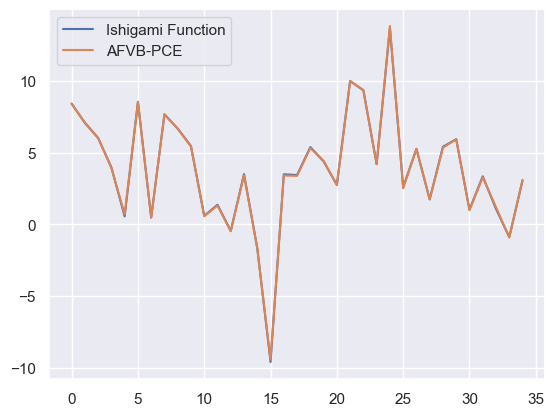

In [62]:
plt.plot(data['Y'], label = "Ishigami Function")
plt.plot(Phi_hat@a_hat, label = "AFVB-PCE")
plt.legend();

In [63]:
active_cols

array([  0,  17,  30,  39,  44,  45, 109, 111, 113, 147])

In [64]:
#add coefficients to mod using mod._coeffs = ...

### Using Test Data

In [65]:
from sklearn.metrics import mean_squared_error

In [66]:
Test_data={'Xi':np.random.uniform(-1, 1, size=(100,d))}

z_1 = Test_data['Xi'][:,0]
z_2 = Test_data['Xi'][:,1]
z_3 = Test_data['Xi'][:,2]

Test_data['Y'] = np.c_[np.sin(np.pi*z_1) + 7*(np.sin(np.pi*z_2))**2 + 0.1*(np.pi*z_3)**4*np.sin(np.pi*z_1)]

In [67]:
Phi_test_full = basis(Test_data['Xi'], p)
Phi_test = basis(Test_data['Xi'],p)[:,active_cols]

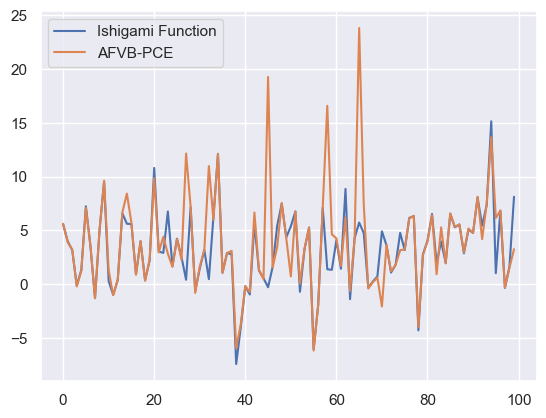

In [68]:
plt.plot(Test_data['Y'], label = "Ishigami Function")
plt.plot(Phi_test@a_hat, label = "AFVB-PCE")
plt.legend();

In [69]:
print("RMSE_full - Training Data:", mean_squared_error(data['Y'], Phi_full@a_full))
print("RMSE_sparse - Training Data:", mean_squared_error(data['Y'], Phi_hat@a_hat))

RMSE_full - Training Data: 1.6506994524118897e-06
RMSE_sparse - Training Data: 0.004191958768175596


In [70]:
a_hat.shape

(10, 1)

In [71]:
print("RMSE_full - Testing Data:", mean_squared_error(Test_data['Y'], Phi_test_full@a_full))
print("RMSE_sparse - Testing Data:", mean_squared_error(Test_data['Y'], Phi_test@a_hat))

RMSE_full - Testing Data: 13.657339756073368
RMSE_sparse - Testing Data: 13.793176635232184


In [14]:
#### The behaviour of this one should be similar to the second problem
#### So the RMSE should reduce when we increase N or p

## PC-VRVM (Tsilifis) - Ishigami Function

In [6]:
################
#### Inputs ####
################
N = 1000 # N --> number of samples
d = 3  # d --> number of random variables
p = 8  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [7]:
##########################################################################################
#### Generate N samples for d random variables and compute the responses at N samples ####
##########################################################################################
# ---- Setting the example: Coeffs, data and chaos model ------

sys.path.append('..')

np.random.seed(9)

data={'xi':np.random.uniform(-1,1,size=(N,d))}
data['y'] = np.sin(np.pi*data['xi'][:,0]) + 7*(np.sin(np.pi*data['xi'][:,1]))**2 + 0.1*(np.pi*data['xi'][:,2])**4*np.sin(np.pi*data['xi'][:,0])


In [12]:
chaos._basis(data['xi']).shape

(1000, 165)

In [13]:
data['y'].shape

(1000,)

0.6839785050458664
Iters = 0          Relative error : 13529.497771921442          
5.61371110417859
4.335210942987711
2.905661379004311
0.1777742847146495
0.6016365284218228
1.6508680058831047
2.4208969374686795
2.7982594255374096
2.667466194704822
2.0492024584130313
Iters = 10          Relative error : 125360.14654506774          
0.7603255114995413
0.0883160580480542
0.011013489496949802
0.010697349919770005
0.0068266256345914655
0.004707944717097234
0.0034192031359125963
0.0025734460959938588
0.0020022775942152293
0.0016055494072020338
Iters = 20          Relative error : 3600.216495914551          
0.0013198136428371754
0.00110594433230915
0.000940240094713829
0.0008082090108487705
0.0007007072515534674
0.0006117119002979621
0.000537074965865969
0.00047382388812522436
0.0004197577699329713
0.00037320430198661825
Iters = 30          Relative error : 1918.5411010420055          
0.00033286644710273094
0.0002977213929966638
0.00026695139426635706
0.00023989495640819314
0.000216011507

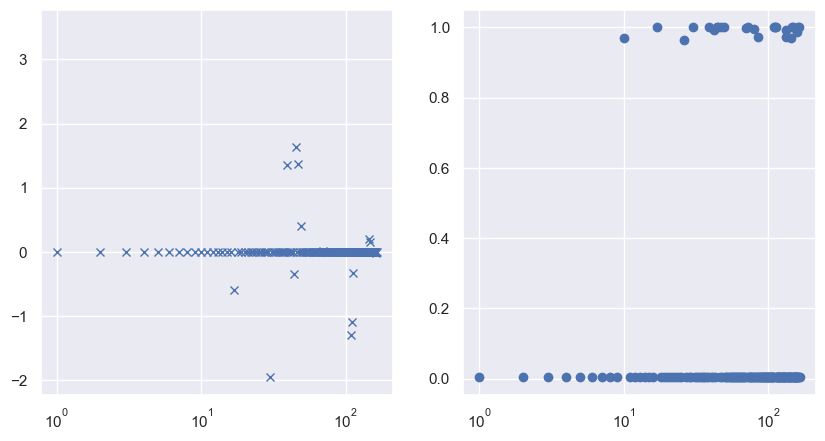

In [8]:
# --- RUN RELEVANCE VECTOR MACHINE FIT
chaos = ChaosModel(d, p, basis, (n,d))

# The success probability for the Bernoulli dinsities is a/(a+b)
# Choices of these parameters allow controling the level of sparsity in the model
a_0 = 0.2
b_0 = 1.0

params = {'omega' : [1e-6, 1e-6], 'tau': [1e-6, 1e-6], 'pi': [ a_0, b_0 ]}

V0 = SparseVariationalOptimizer(chaos, data, params)

c_sol, omega_sol, tau_sol, z_sol, pi_sol, iters, elbo  = V0.optimize(tol = .0001)

df_c = pd.DataFrame(c_sol, columns=['mu','rho'])
df_o = pd.DataFrame(omega_sol, columns=['kappa','lambda'])
df_t = pd.DataFrame(tau_sol, columns=['m','n'])
df_z = pd.DataFrame(z_sol, columns=['pi'])
df_p = pd.DataFrame(pi_sol, columns=['alpha','beta'])
df_elbo = pd.DataFrame(elbo, columns = ['elbo'])

import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax1.plot(c_sol[:,0], 'x')
ax1.set_xscale('log')
ax2 = fig.add_subplot(122)
ax2.plot(z_sol, 'o')
ax2.set_xscale('log')
plt.show()

In [58]:
active_indices = np.array(range(0,n))[z_sol>0.01]

In [59]:
chaos._coeffs = c_sol[:,0]

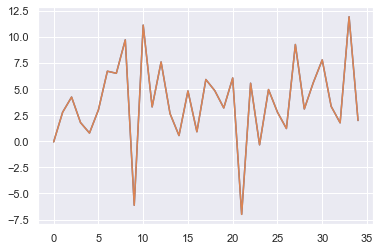

In [60]:
plt.plot(data['y'][0:35])
plt.plot(chaos.eval(data['xi'], active_indices)[0:35]);

### Using Test Data

In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
np.random.seed(99)
Test_data={'xi':np.random.uniform(-1, 1, size=(100,d))}

z_1 = Test_data['xi'][:,0]
z_2 = Test_data['xi'][:,1]
z_3 = Test_data['xi'][:,2]

Test_data['y'] = np.c_[np.sin(np.pi*z_1) + 7*(np.sin(np.pi*z_2))**2 + 0.1*(np.pi*z_3)**4*np.sin(np.pi*z_1)]

In [63]:
print("RMSE - Training Data:", mean_squared_error(data['y'], chaos.eval(data['xi'])))
print("RMSE - Training Data:", mean_squared_error(data['y'], chaos.eval(data['xi'], active_indices)))

RMSE - Training Data: 1.7327292350847173e-05
RMSE - Training Data: 1.912114409535604e-05


In [64]:
print("RMSE - Testing Data:", mean_squared_error(Test_data['y'], chaos.eval(Test_data['xi'])))
print("RMSE - Testing Data:", mean_squared_error(Test_data['y'], chaos.eval(Test_data['xi'], active_indices)))

RMSE - Testing Data: 4.500023609255545e-05
RMSE - Testing Data: 4.5915112394470694e-05
